<a href="https://colab.research.google.com/github/NehaSontakk/Functional-Characterization-of-Gene-Sets-using-KEGG-COG-GO/blob/main/Functional_Annotation_and_Enrichment_calculations_on_dataset_of_interest_using_KEGG%2C_COG%2C_GO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from scipy.stats import hypergeom
import numpy as np
from scipy.stats import fisher_exact
from statsmodels.sandbox.stats.multicomp import multipletests
import seaborn as sns
import glob

## Upload the other files from github to the file folder on the right (just drag and drop), file structure should look like the picture below:

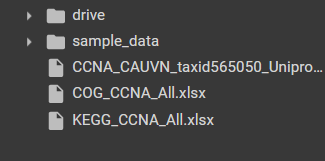

## Upload your excel files to the data folder, each excel file should just be a set of genes of interest in a column on an .xlsx file.

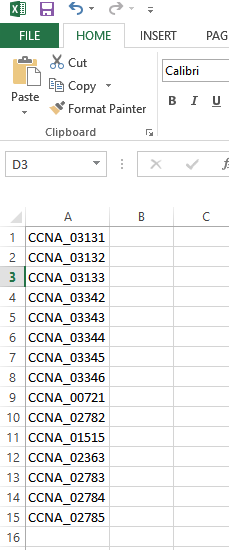

In [2]:
!mkdir /content/data/

### The following files are custom created for Caulobacter by Neha S.

1.   KEGG identifiers have been matched to Caulobacter genes via data on KEGG ftp.
2.   COG files have also been created manually from the Caulo data on the COG website.
3.   GO ontologies for Caulobacter have been downloaded directly from the website.

In [16]:
#kegg
kegg_data = pd.read_excel("/content/KEGG_CCNA_All.xlsx").set_index("Gene")
#go
go_data = pd.read_excel("/content/CCNA_CAUVN_taxid565050_Uniprot_GOA_240323.xlsx").set_index("Gene Locus tags")
#cog
cog_data_with_duplicates = pd.read_excel("/content/COG_CCNA_All.xlsx")
cog_data = pd.read_excel("/content/COG_CCNA_All.xlsx").set_index("gene")
cog_data = cog_data.loc[:, ~cog_data.columns.str.contains('^Unnamed')]

## KEGG

KEGG has three levels of data, the broadest abstraction is Pathways, followed by Processes and then pathway subcategories.

For example:


```
| Gene       | KEGG Identifiers | KEGG Processes        | KEGG Pathway Subcategory | KEGG Pathway |
| ---------- | ---------------- | --------------------- | ------------------------ | ------------ |
| CCNA_00002 | 00240            | Pyrimidine metabolism | Nucleotide metabolism    | Metabolism   |
```



In [18]:
kegg_data.head()

,KEGG Identifiers,KEGG Processes,KEGG Pathway Subcategory,KEGG Pathway
Gene,,,,
CCNA_00002,240.0,Pyrimidine metabolism,Nucleotide metabolism,Metabolism
CCNA_00002,1100.0,Metabolic pathways,Global and overview maps,Metabolism
CCNA_00002,1232.0,Nucleotide metabolism,Global and overview maps,Metabolism
CCNA_00003,400.0,"Phenylalanine, tyrosine and tryptophan biosynt...",Amino acid metabolism,Metabolism
CCNA_00003,999.0,Biosynthesis of various plant secondary metabo...,Biosynthesis of other secondary metabolites,Metabolism


In [4]:
kegg_data.columns

Index(['KEGG Identifiers', 'KEGG Processes', 'KEGG Pathway Subcategory',
       'KEGG Pathway'],
      dtype='object')

In [5]:
kegg_data['Kegg Data'] = kegg_data['KEGG Processes']+"_"+kegg_data['KEGG Pathway Subcategory']+"_"+kegg_data['KEGG Pathway']
kegg_coverage = kegg_data[['Kegg Data']].reset_index()
kegg_coverage['Kegg Data'] = kegg_coverage['Kegg Data'].astype("str")
kegg_coverage = kegg_coverage.groupby('Gene')['Kegg Data'].agg(', '.join)

In [6]:
#creating a one hot encoded matrix for ischer analysis
kegg_pathway_matrix = pd.get_dummies(kegg_data['KEGG Pathway'])
kegg_pathway_matrix_totals = pd.DataFrame(kegg_pathway_matrix.sum(axis=0)).iloc[:-1].rename(columns={0:"Total"})
#
kegg_pathway_subcategory_matrix = pd.get_dummies(kegg_data['KEGG Pathway Subcategory'])
kegg_pathway_subcategory_matrix_totals = pd.DataFrame(kegg_pathway_subcategory_matrix.sum(axis=0)).iloc[:-1].rename(columns={0:"Total"})
#
kegg_process_matrix = pd.get_dummies(kegg_data['KEGG Processes'])
kegg_process_matrix_totals = pd.DataFrame(kegg_process_matrix.sum(axis=0)).iloc[:-1].rename(columns={0:"Total"})

# COG

COG dataset has been some-what hand made since their data is not fully open-sourced. It has a single level of abstraction for now.

In [20]:
cog_data.head()

,Gene ID,Name,Function,COG_category
gene,,,,
CCNA_00003,643618224,shikimate dehydrogenase (EC 1.1.1.25),COG0169,Amino acid transport and metabolism
CCNA_00029,643618250,lysine exporter protein,COG1280,Amino acid transport and metabolism
CCNA_00086,643618308,glutamate dehydrogenase (NAD) (EC 1.4.1.2),COG2902,Amino acid transport and metabolism
CCNA_00091,643618313,"transporter, drug/metabolite exporter family",COG0697,Amino acid transport and metabolism
CCNA_00096,643618318,L-asparaginase,COG1446,Amino acid transport and metabolism


In [7]:
cog_coverage = cog_data[['COG_category']].reset_index()
cog_coverage['COG Data'] = cog_coverage['COG_category'].astype("str")
cog_coverage = cog_coverage.groupby('gene')['COG Data'].agg(', '.join).reset_index()
cog_coverage.rename(columns={"gene":"Gene"},inplace=True)
#creating a one hot encoded matrix for fischer analysis
cog_pathway_matrix_totals = pd.DataFrame(cog_data.sum(axis=0)).iloc[:-1].rename(columns={0:"Total"})

## GO or Gene Ontology resource

A GO annotation is a statement about the function of a particular gene. GO annotations are created by associating a gene or gene product with a GO term. Together, these statements comprise a “snapshot” of current biological knowledge. Hence, GO annotations capture statements about how a gene functions at the molecular level, where in the cell it functions, and what biological processes (pathways, programs) it helps to carry out.

Associations of gene products to GO terms are statements that describe:

    Molecular Function: the molecular activities of individual gene products
    Cellular Component: where the gene products are active
    Biological Process: the pathways and larger processes to which that gene product’s activity contributes


In [19]:
go_data.head()

,Unnamed: 0,Entry,Reviewed,Entry Name,Protein names,Gene Names,Length,Gene Ontology (biological process),Gene Ontology (cellular component),Gene Ontology (GO),Gene Ontology (molecular function),Gene Ontology IDs,DNA binding
Gene Locus tags,,,,,,,,,,,,,
CCNA_00317,0,B8GYI7,reviewed,OBG_CAUVN,GTPase Obg/CgtA (EC 3.6.5.-) (CgtAC) (GTP-bind...,cgtA obg CCNA_00317,354,ribosome biogenesis [GO:0042254],cytoplasm [GO:0005737],cytoplasm [GO:0005737]; GTP binding [GO:000552...,GTP binding [GO:0005525]; GTPase activity [GO:...,GO:0000287; GO:0003924; GO:0005525; GO:0005737...,NaN
CCNA_02546,1,B8GZM2,reviewed,PLED_CAUVN,Response regulator PleD (Stalked cell differen...,pleD CCNA_02546,454,cell cycle [GO:0007049]; cell differentiation ...,cytoplasm [GO:0005737],cytoplasm [GO:0005737]; diguanylate cyclase ac...,diguanylate cyclase activity [GO:0052621]; GTP...,GO:0000160; GO:0005525; GO:0005737; GO:0007049...,NaN
CCNA_03334,2,B8H444,reviewed,FTSH_CAUVN,ATP-dependent zinc metalloprotease FtsH (EC 3....,ftsH CCNA_03334,626,cell cycle [GO:0007049]; cell division [GO:005...,plasma membrane [GO:0005886],plasma membrane [GO:0005886]; ATP binding [GO:...,ATP binding [GO:0005524]; ATP hydrolysis activ...,GO:0004176; GO:0004222; GO:0005524; GO:0005886...,NaN
CCNA_00253,3,A0A0H3C356,unreviewed,A0A0H3C356_CAUVN,Aspartate-semialdehyde dehydrogenase (ASA dehy...,asd CCNA_00253,342,'de novo' L-methionine biosynthetic process [G...,NaN,aspartate-semialdehyde dehydrogenase activity ...,aspartate-semialdehyde dehydrogenase activity ...,GO:0004073; GO:0009088; GO:0009089; GO:0009097...,NaN
CCNA_00931,4,A0A0H3C6U2,unreviewed,A0A0H3C6U2_CAUVN,Multifunctional fusion protein [Includes: GTP ...,ribA ribB CCNA_00931,400,riboflavin biosynthetic process [GO:0009231],NaN,"3,4-dihydroxy-2-butanone-4-phosphate synthase ...","3,4-dihydroxy-2-butanone-4-phosphate synthase ...",GO:0000287; GO:0003935; GO:0005525; GO:0008270...,NaN


In [8]:
go_data['GO Data'] = go_data['Gene Ontology (biological process)']+','+go_data['Gene Ontology (cellular component)']+","+go_data['Gene Ontology (GO)']+","+go_data['Gene Ontology (molecular function)']
go_coverage = go_data[['GO Data']].reset_index()
go_coverage['GO Data'] = go_coverage['GO Data'].astype("str")
go_coverage = go_coverage.groupby('Gene Locus tags')['GO Data'].agg(', '.join).reset_index()
go_coverage.rename(columns={"Gene Locus tags":"Gene"},inplace=True)

In [9]:
#creating a one hot encoded matrix for ischer analysis
go_biological_process_matrix = pd.get_dummies(go_data['Gene Ontology (biological process)'])
go_biological_process_matrix_totals = pd.DataFrame(go_biological_process_matrix.sum(axis=0)).iloc[:-1].rename(columns={0:"Total"})
#
go_cellular_component_matrix = pd.get_dummies(go_data['Gene Ontology (cellular component)'])
go_cellular_component_matrix_totals = pd.DataFrame(go_cellular_component_matrix.sum(axis=0)).iloc[:-1].rename(columns={0:"Total"})
#
go_molecular_function_matrix = pd.get_dummies(go_data['Gene Ontology (molecular function)'])
go_molecular_function_matrix_totals = pd.DataFrame(go_molecular_function_matrix.sum(axis=0)).iloc[:-1].rename(columns={0:"Total"})

## Enrichment Analysis (Fischers Exact Test)

High-throughput experimental measurements can result in lists of genes that are difficult to interpret at face value. ‘Enrichment analyses’ aim to draw out meaningful, potentially interesting biological themes from the gene-based measurements.

**Fisher’s Exact Test** seeks to identify those gene sets that share an unusually large number of genes with a list derived from experimental measurements

For the math behind this go to: https://www.pathwaycommons.org/guide/primers/statistics/fishers_exact_test/

In [10]:
def fischer_test_for_all(data_x, damage_name):
  p_val_list = []
  for i in range(0,len(data_x[damage_name])):
    deg_and_func = data_x[damage_name].iloc[i]
    nodeg_and_func = data_x['Total'].iloc[i] - data_x[damage_name].iloc[i]
    deg_and_nofunc = data_x[damage_name].sum() - data_x[damage_name].iloc[i]
    nodeg_and_nofunc = data_x['Total'].sum() - data_x['Total'].iloc[i]
    table = np.array([[deg_and_func,nodeg_and_func],[deg_and_nofunc,nodeg_and_nofunc]])
    M = table.sum()
    n = table[0].sum()
    N = table[:, 0].sum()
    start, end = hypergeom.support(M, n, N)
    hypergeom.pmf(np.arange(start, end+1), M, n, N)
    oddsr, p = fisher_exact(table, alternative='two-sided')
    p_val_list.append(p)
  return multipletests(p_val_list, method='bonferroni')[1]

In [11]:
def get_pathway_data(dataset,title_patway,pathway_totals,pathway_dataset):
  dataset_path = pathway_dataset[pathway_dataset.index.isin(dataset.index)]
  dataset_path_totals = pd.DataFrame(dataset_path.sum(axis=0)).rename(columns={0:title_patway}).iloc[:-1]
  Path_Totals = pd.merge(pathway_totals,dataset_path_totals,left_index=True,right_index=True,how="outer")
  Path_Totals[str(title_patway)+' p-values'] = fischer_test_for_all(Path_Totals,title_patway)
  return Path_Totals, dataset_path

In [12]:
!mkdir /content/Enrichment/
!mkdir /content/Genes_and_functions/

In [13]:
def run_pathway_analysis_for_all_files(file_name,new_filename):
  df = pd.read_excel(file_name,header=None,names=['Gene'])
  print(df)
  df['Geneset_Interest'] = "Geneset_of_Interest"
  df.set_index("Gene",inplace=True)
  pd.merge(pd.merge(pd.merge(df,kegg_coverage,how="left",on="Gene"),cog_coverage,how="left",on="Gene"),go_coverage,how="left",on="Gene").to_excel("/content/Genes_and_functions/"+str(new_filename)+"_KEGG_COG_GO.xlsx")
  #Kegg pathway
  kegg_pathway_matrix_enrichment, kegg_pathway_matrix_gene_presab_matrix = get_pathway_data(df,"Gene Set of Interest kegg pathway",kegg_pathway_matrix_totals,kegg_pathway_matrix)
  kegg_pathway_matrix_enrichment.to_excel("/content/Enrichment/"+str(new_filename)+"_kegg_pathway_matrix_enrichment.xlsx")
  kegg_pathway_matrix_gene_presab_matrix.to_excel("/content/Genes_and_functions/"+str(new_filename)+"_kegg_pathways_and_genes.xlsx")
  #Kegg process
  kegg_process_matrix_enrichment, kegg_process_matrix_gene_presab_matrix = get_pathway_data(df,"Gene Set of Interest kegg process",kegg_process_matrix_totals,kegg_process_matrix)
  kegg_process_matrix_enrichment.to_excel("/content/Enrichment/"+str(new_filename)+"_kegg_process_matrix_enrichment.xlsx")
  kegg_process_matrix_gene_presab_matrix.to_excel("/content/Genes_and_functions/"+str(new_filename)+"_kegg_process_and_genes.xlsx")
  #Kegg pathway subcategories
  kegg_pathway_subcategory_matrix_enrichment, kegg_pathway_subcategory_matrix_gene_presab_matrix = get_pathway_data(df,"Gene Set of Interest kegg pathway subcategory",kegg_pathway_subcategory_matrix_totals,kegg_pathway_subcategory_matrix)
  kegg_pathway_subcategory_matrix_enrichment.to_excel("/content/Enrichment/"+str(new_filename)+"_kegg_pathway_subcategory_matrix_enrichment.xlsx")
  kegg_pathway_subcategory_matrix_gene_presab_matrix.to_excel("/content/Genes_and_functions/"+str(new_filename)+"_kegg_pathway_subcategory_and_genes.xlsx")
  #COG
  cog_pathway_matrix_enrichment, cog_pathway_matrix_gene_presab_matrix = get_pathway_data(df,"Gene Set of Interest cog pathway",cog_pathway_matrix_totals,cog_data)
  cog_pathway_matrix_enrichment.to_excel("/content/Enrichment/"+str(new_filename)+"_COG_pathway_enrichment.xlsx")
  cog_pathway_matrix_gene_presab_matrix.to_excel("/content/Genes_and_functions/"+str(new_filename)+"_COG_pathways_and_genes.xlsx")
  #GO Biological Pathways
  go_biological_process_matrix_enrichment, go_biological_process_matrix_gene_presab_matrix = get_pathway_data(df,"Gene set of interest GO biological pathway",go_biological_process_matrix_totals,go_biological_process_matrix)
  go_biological_process_matrix_enrichment.to_excel("/content/Enrichment/"+str(new_filename)+"_GO_biological_process_enrichment.xlsx")
  go_biological_process_matrix_gene_presab_matrix.to_excel("/content/Genes_and_functions/"+str(new_filename)+"_GO_biological_process_and_genes.xlsx")
  #GO Cellular Components
  go_cellular_component_matrix_enrichment, go_cellular_component_matrix_gene_presab_matrix = get_pathway_data(df,"Gene set of interest GO cellular components",go_cellular_component_matrix_totals,go_cellular_component_matrix)
  go_cellular_component_matrix_enrichment.to_excel("/content/Enrichment/"+str(new_filename)+"_GO_cellular_components_enrichment.xlsx")
  go_cellular_component_matrix_gene_presab_matrix.to_excel("/content/Genes_and_functions/"+str(new_filename)+"_GO_cellular_components_and_genes.xlsx")
  #GO Molecular Functions
  go_molecular_function_matrix_enrichment, go_molecular_function_matrix_gene_presab_matrix = get_pathway_data(df,"Gene set of interest GO molecular function",go_molecular_function_matrix_totals,go_molecular_function_matrix)
  go_molecular_function_matrix_enrichment.to_excel("/content/Enrichment/"+str(new_filename)+"_GO_molecular_function_enrichment.xlsx")
  go_molecular_function_matrix_gene_presab_matrix.to_excel("/content/Genes_and_functions/"+str(new_filename)+"_GO_molecular_function_and_genes.xlsx")

This gives us outputs for Kegg Pathways

In [14]:
for i in glob.glob("/content/data/*.xlsx"):
  print("Analysing "+i)
  new_filename = str(i).split("/")[-1].split('.xlsx')[0]
  print("Files will be stored at "+new_filename)
  run_pathway_analysis_for_all_files(i,new_filename)


## Find Outputs in



1.   Enrichment.zip (contains all p-values for functions associated with gene set of interest)
2.   Genes_and_functions.zip (contains gene names and the functions associated with the genes)




